# Decomposition framework of the PySAL *segregation* module

This is a notebook that explains a step-by-step procedure to perform decomposition on comparative segregation measures.

First, let's import all the needed libraries.

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pysal.explore import segregation
from pysal.explore.segregation.decompose_segregation import Decompose_Segregation

In this example, we are going to use census data that the user must download its own copy, following similar guidelines explained in https://github.com/spatialucr/geosnap/tree/master/geosnap/data where you should download the full type file  of 2010. The zipped file download will have a name that looks like `LTDB_Std_All_fullcount.zip`. After extracting the zipped content, the filepath of the data should looks like this:

In [2]:
#filepath = '~/std_2010_fullcount.csv'

Then, we read the data:

In [3]:
df = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")

We are going to work with the variable of the nonhispanic black people (`nhblk10`) and the total population of each unit (`pop10`). So, let's read the map of all census tracts of US and select some specific columns for the analysis:

In [4]:
# This file can be download here: https://drive.google.com/open?id=1gWF0OCn6xuR_WrEj7Ot2jY6KI2t6taIm
with open('data/tracts_US.pkl', 'rb') as input:
    map_gpd = pickle.load(input)
    
map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
gdf_pre = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'trtid10')
gdf = gdf_pre[['GEOID10', 'geometry', 'pop10', 'nhblk10']]

In this notebook, we use the Metropolitan Statistical Area (MSA) of US (we're also using the word 'cities' here to refer them). So, let's read the correspondence table that relates the tract id with the corresponding Metropolitan area...

In [5]:
# You can download this file here: https://drive.google.com/open?id=10HUUJSy9dkZS6m4vCVZ-8GiwH0EXqIau
with open('data/tract_metro_corresp.pkl', 'rb') as input:
    tract_metro_corresp = pickle.load(input).drop_duplicates()

..and merge them with the previous data.

In [6]:
merged_gdf = gdf.merge(tract_metro_corresp, left_on = 'GEOID10', right_on = 'geoid10')

We now build the composition variable (`compo`) which is the division of the frequency of the chosen group and total population. Let's inspect the first rows of the data.

In [7]:
merged_gdf['compo'] = np.where(merged_gdf['pop10'] == 0, 0, merged_gdf['nhblk10'] / merged_gdf['pop10'])
merged_gdf.head()

,GEOID10,geometry,pop10,nhblk10,geoid10,metro_id,numeric_id,geoid,name,compo
0,01001020801,"POLYGON ((-86.456273 32.405837, -86.4570349999...",3081,293,01001020801,33860,33860,33860,"Montgomery, AL",0.095099
1,01001020802,"POLYGON ((-86.412497 32.589422, -86.412442 32....",10435,1420,01001020802,33860,33860,33860,"Montgomery, AL",0.136080
2,01001020200,"POLYGON ((-86.467354 32.459308, -86.46764 32.4...",2170,1226,01001020200,33860,33860,33860,"Montgomery, AL",0.564977
3,01001020700,"POLYGON ((-86.46106999999999 32.42709, -86.461...",2891,452,01001020700,33860,33860,33860,"Montgomery, AL",0.156347
4,01001020600,"POLYGON ((-86.470524 32.456117, -86.4700469999...",3668,776,01001020600,33860,33860,33860,"Montgomery, AL",0.211559


Now, we chose two different metropolitan areas to compare the degree of segregation.

## Map of the composition of the Metropolitan area of Los Angeles

(-119.02865769999998, -117.3360503, 32.6463769, 34.9269651)

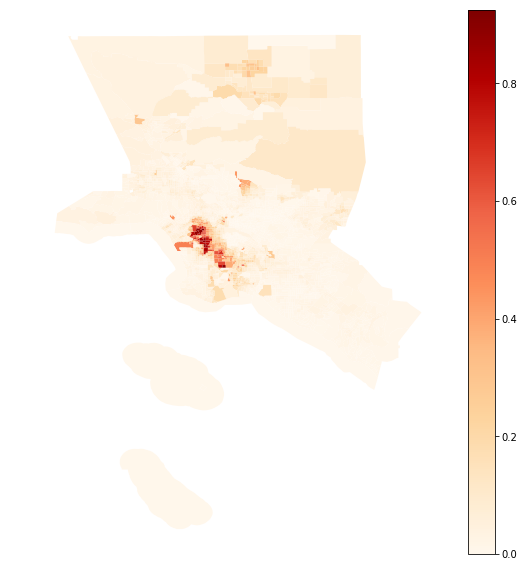

In [8]:
la_2010 = merged_gdf.loc[(merged_gdf.name == "Los Angeles-Long Beach-Anaheim, CA")]
la_2010.plot(column = 'compo', figsize = (10, 10), cmap = 'OrRd', legend = True)
plt.axis('off')

## Map of the composition of the Metropolitan area of New York

(-75.5381038, -71.59841419999998, 39.36886419999999, 41.70820779999999)

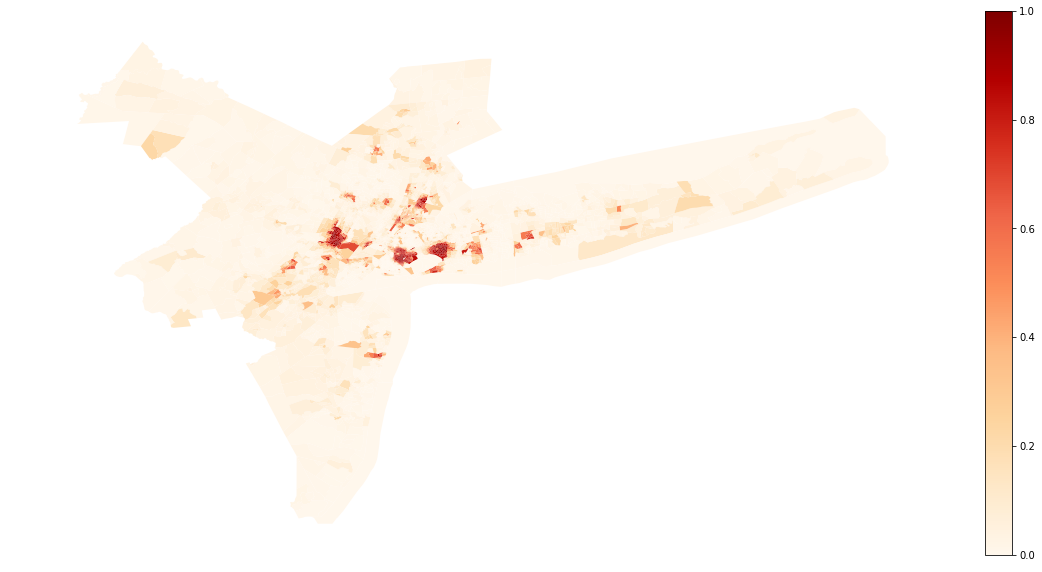

In [9]:
ny_2010 = merged_gdf.loc[(merged_gdf.name == 'New York-Newark-Jersey City, NY-NJ-PA')]
ny_2010.plot(column = 'compo', figsize = (20, 10), cmap = 'OrRd', legend = True)
plt.axis('off')

We first compare the Gini index of both cities. Let's import the `Gini_Seg` class from `segregation`, fit both indexes and check the difference in point estimation.

In [10]:
from pysal.explore.segregation.non_spatial_indexes import Gini_Seg

G_la = Gini_Seg(la_2010, 'nhblk10', 'pop10')
G_ny = Gini_Seg(ny_2010, 'nhblk10', 'pop10')

G_la.statistic - G_ny.statistic

-0.10652888790131243

Let's decompose these difference according to *Rey, S. et al "Comparative Spatial Segregation Analytics". Forthcoming*. You can check the options available in this decomposition below:

In [11]:
help(Decompose_Segregation)

Help on class Decompose_Segregation in module segregation.decompose_segregation:

class Decompose_Segregation(builtins.object)
 |  Decompose segregation differences into spatial and attribute components.
 |  
 |  Given two segregation indices of the same type, use Shapley decomposition
 |  to measure whether the differences between index measures arise from
 |  differences in spatial structure or population structure
 |  
 |  Parameters
 |  ----------
 |  index1 : segregation.SegIndex class
 |      First SegIndex class to compare.
 |  index2 : segregation.SegIndex class
 |      Second SegIndex class to compare.
 |  counterfactual_approach : str, one of
 |                            ["composition", "share", "dual_composition"]
 |      The technique used to generate the counterfactual population
 |      distributions.
 |  
 |  Attributes
 |  ----------
 |  
 |  c_s : float
 |      Shapley's Spatial Component of the decomposition
 |              
 |  c_a : float
 |      Shapley's Attribut

## Composition Approach (default)

The difference of -0.10653 fitted previously, can be decomposed into two components. The Spatial component and the attribute component. Let's estimate both, respectively.

In [12]:
DS_composition = Decompose_Segregation(G_la, G_ny)
DS_composition.c_s

0.029575766160051364

In [13]:
DS_composition.c_a

-0.1361046540613638

So, the first thing to notice is that attribute component, i.e., given by a difference in the population structure (in this case, the composition) plays a more important role in the difference, since it has a higher absolute value.

The difference in the composition can be inspected in the plotting method with the type `cdfs`:

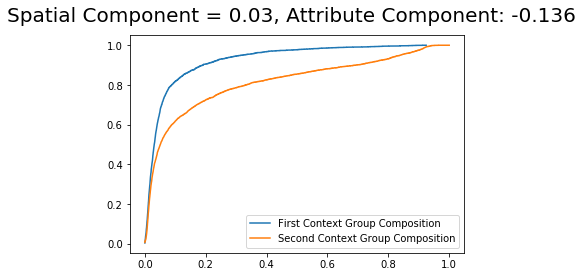

In [14]:
DS_composition.plot(plot_type = 'cdfs')

If your data is a GeoDataFrame, it is also possible to visualize the counterfactual compositions with the argument `plot_type = 'maps'`

The first and second contexts are Los Angeles and New York, respectively.

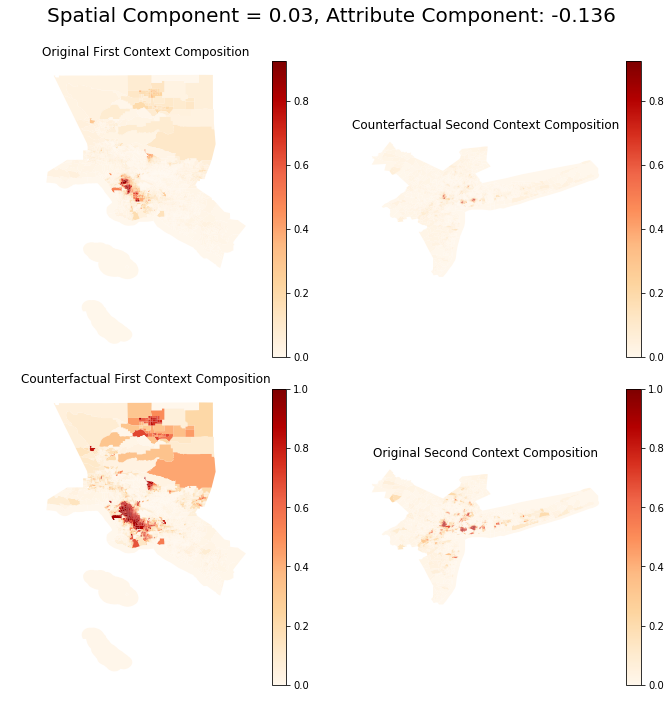

In [15]:
DS_composition.plot(plot_type = 'maps')

*Note that in all plotting methods, the title presents each component of the decomposition performed.*

## Share Approach

The share approach takes into consideration the share of each group in each city. Since this approach takes into consideration the focus group and the complementary group share to build the "counterfactual" total population of each unit, it is of interest to inspect all these four cdf's.

*ps.: The share is the population frequency of each group in each unit over the total population of that respectively group.*

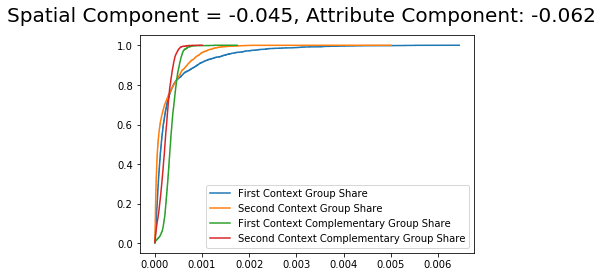

In [16]:
DS_share = Decompose_Segregation(G_la, G_ny, counterfactual_approach = 'share')
DS_share.plot(plot_type = 'cdfs')

We can see that curve between the contexts are closer to each other which represent a drop in the importance of the population structure (attribute component) to -0.062. However, this attribute still overcomes the spatial component (-0.045) in terms of importance due to both absolute magnitudes.

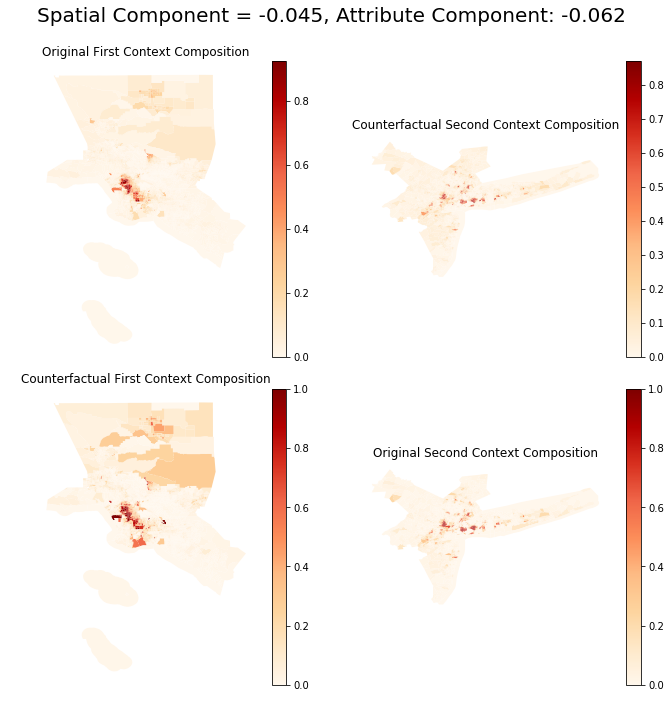

In [17]:
DS_share.plot(plot_type = 'maps')

We can see that the counterfactual maps of the composition (outside of the main diagonal), in this case, are slightly different from the previous approach.

## Dual Composition Approach

The `dual_composition` approach is similar to the composition approach. However, it uses also the counterfactual composition of the cdf of the complementary group.

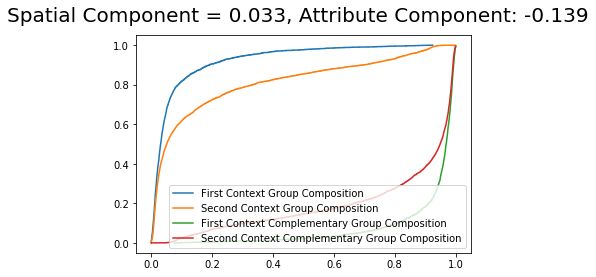

In [18]:
DS_dual = Decompose_Segregation(G_la, G_ny, counterfactual_approach = 'dual_composition')
DS_dual.plot(plot_type = 'cdfs')

It is possible to see that the component values are very similar with slight changes from the `composition` approach.

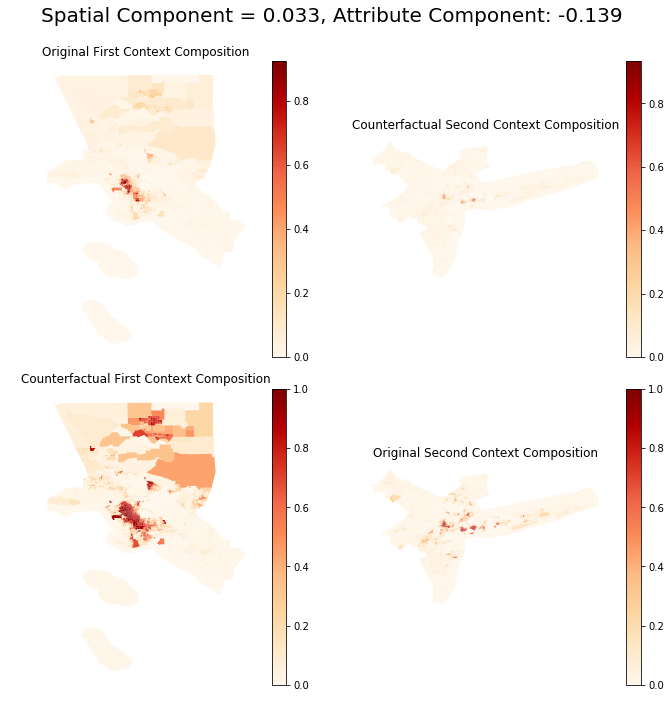

In [19]:
DS_dual.plot(plot_type = 'maps')

The counterfactual distributions are virtually the same (but not equal) as the one from the `composition` approach.

## Inspecting a different index: Relative Concentration

In [20]:
from pysal.explore.segregation.spatial_indexes import Relative_Concentration

RCO_la = Relative_Concentration(la_2010, 'nhblk10', 'pop10')
RCO_ny = Relative_Concentration(ny_2010, 'nhblk10', 'pop10')

RCO_la.statistic - RCO_ny.statistic

-0.4251693177385222

In [21]:
RCO_DS_composition = Decompose_Segregation(RCO_la, RCO_ny)
RCO_DS_composition.c_s

-0.37581968640142394

In [22]:
RCO_DS_composition.c_a

-0.0493496313370983

It is possible to note that, in this case, the spatial component is playing a much more relevant role in the decomposition.